In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [2]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 123

Срок выполнения задания: 13 апреля 17:00.


### Задание
Вам предстоит разработать дизайн эксперимента по тестированию монетизационных продуктов.
В конечном счёте, в монтизационных продуктах нас всегда интересует увеличение выручки, 
но к сожалению не всегда мы можем зафиксировать изменение именно этой метрики.

#### Кейс
Вы аналитик в продуктовой дискавери команде.
На текущий момент приближается начало нового квартала и вам необходимо спланировать
эксперименты в нём.

У вас есть два продукта:
- один базовый продукт, который предоставляет минимальный набор услуг на вашем ресурсе;
- один продвинутый продукт, который предоставляет расширенный набор услуг.

На текущий момент на квартал у вашей команды есть для проверки две гипотезы:
- Дополнительное информирование об эффективности услуг будет стимулировать их покупку;
- Повышение цены базового продукта должно стимулировать покупку продвинутого продукта


#### Для планирования эксперимента изучите данные и метрики (2 балла):

- Загрузите файл и изучите данные;
- Подумайте над тем, какие метрики можно выделить на основе этих данных: выручка, пользователи, транзакции, средний чек и т.д.
- Постройте графики плотности распределения для этих метрик и сделайте выводы о характере распределений: тип, наличие выбросов, насколько сильный разброс;
- Изучите основные статистики этих метрик: среднее, стандартное отклонение;
- Изучите то, насколько эти статистики подвержены сезональности.


#### Формализуйте гипотезы (4 балла):

- Опишите метрики и статистики, изменение которых вы ожидаете;
- Предположите какое относительное изменение этих статистик в процентах вы ожидаете.

#### Предскажите минимально детектируемый эффект для своих метрик и спланируйте эксперименты внутри квартала (4 балла):

- Принимая в расчёт максимально возможные размеры групп и ограничения по длительности в квартал рассмотрите разные планы проведения тестов и предскажите их чувствительность;
- Определите наиболее оптимальный план экспериментов. Обоснуйте, почему вы его считаете оптимальным.


#### * Оптимизация плана (2 балла):
Предложите варианты ускорения экспериментов — всегда могут образоваться ситуации, когда ваши гипотезы не подтвердились и они требуют изменения или уточнения и необходимости повторных тестов. Цели достигать всегда хорошо в рамках отведённого на них срока. Какие параметры экспериментов вы поменяете? К каким последствиям могут привести такие изменения?

#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

product - тип продукта

amount - сумма покупок

transactions - количество транзакций


In [46]:
df = pd.read_csv('user_transactions.csv')
df['event_date'] = df.event_date.apply(date_converter)
df.sample(5)

,event_date,user_id,product,amount,transactions
882613,2020-12-03,4996044890967705875,basic,80.0,1
320171,2020-10-14,7561319082721076589,basic,89.0,1
1031618,2020-12-07,5973386416195372128,basic,59.0,1
1277709,2020-12-29,1241700791665327743,advanced,76.0,1
462236,2020-11-08,8641890945436980619,advanced,140.0,1


In [8]:
print(df.shape)
df.describe()

(1278186, 5)


,user_id,amount,transactions
count,1.278186e+06,1.278186e+06,1.278186e+06
mean,4.614241e+18,2.394618e+02,1.292690e+00
std,2.657074e+18,3.719033e+02,1.511153e+00
min,1.809139e+12,8.000000e+00,1.000000e+00
25%,2.311730e+18,8.900000e+01,1.000000e+00
50%,4.622499e+18,1.490000e+02,1.000000e+00
75%,6.906575e+18,2.590000e+02,1.000000e+00
max,9.223367e+18,1.081860e+05,7.680000e+02


За какой временной период имеются данные?

In [69]:
print(f'{df.event_date.min()} -- {df.event_date.max()}')

2020-09-29 00:00:00 -- 2020-12-29 00:00:00


In [92]:
dates = df.event_date.unique()
timedeltas = np.roll(dates, -1)[:-1] - dates[:-1]
deltas_in_days = list(map(lambda x: float(x / 1e9 / 3600 / 24), timedeltas))
print('Максимальный пропуск в днях:', max(deltas_in_days))

Максимальный пропуск в днях: 1.0


Дисбалансность классов `basic` и `advanced`

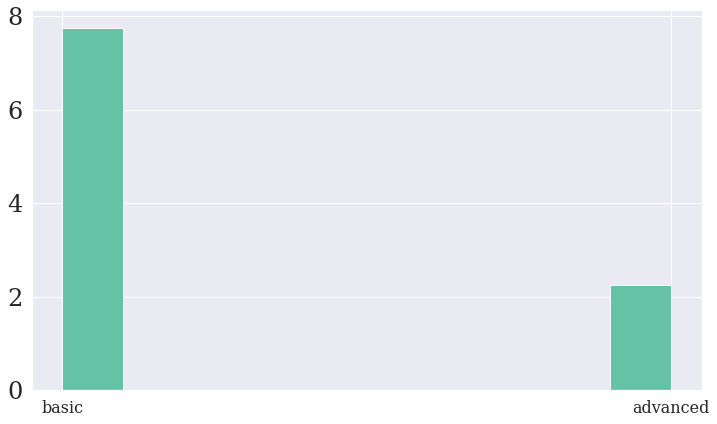

In [26]:
plt.hist(df['product'].values, density=True)
plt.grid(True)
plt.show()

Примерное соотношение 80/20

Взглянем на сумму покупок и число транзакций отдельно по типу продукта

In [57]:
df.groupby('product')[['amount', 'transactions']].describe(
    percentiles=[.25, .5, .75, .95, .99]
)

amount                                                             \
             count        mean         std   min    25%    50%    75%     95%   
product                                                                         
advanced  287758.0  499.179714  583.444202  20.0  202.0  369.0  599.0  1338.0   
basic     990428.0  164.003625  233.032281   8.0   80.0  120.0  199.0   399.0   

                            transactions                                     \
              99%       max        count      mean       std  min  25%  50%   
product                                                                       
advanced  2799.43   40653.0     287758.0  1.278383  1.453016  1.0  1.0  1.0   
basic      813.00  108186.0     990428.0  1.296846  1.527605  1.0  1.0  1.0   

                                
          75%  95%  99%    max  
product                         
advanced  1.0  3.0  6.0  227.0  
basic     1.0  3.0  6.0  768.0

**Вывод:**  
1. Пользователи улучшенной версии продукта в среднем тратят в 3 раза больше (и по арифм.среднему, и по медиане), чем пользователи базовой версии продукта  
2. Дисперсия выручки велика -- больше среднего  
3. По транзакциям пользователи ничем не отличаются

Отсеим чрезмерно активных пользователей

In [55]:
df_cut = df[df.amount < df.amount.quantile(.99)]
print(df.amount.quantile(.99))

1558.1499999999069


Нарисуем гистограмки `amount` и `transactions` по группам

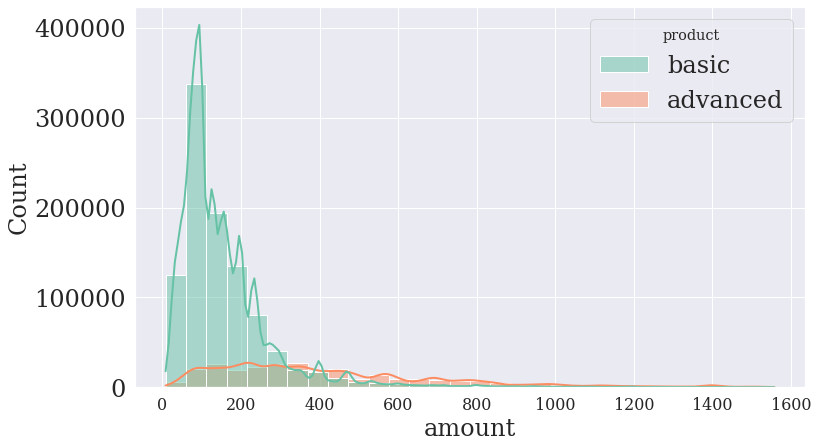

In [47]:
sns.histplot(data=df_cut, x='amount', hue='product', bins=30, kde=True);

Видим, что у распр-ия `advanced` более тяжёлый хвост

Изменение выруски и числа транзакций по дням 

In [62]:
amount_ttl_through_time = df.groupby(['product', 'event_date'])['amount'].sum()
amount_mean_through_time = df.groupby(['product', 'event_date'])['amount'].mean()
transactions_through_time = df.groupby(['product', 'event_date'])['transactions'].sum()

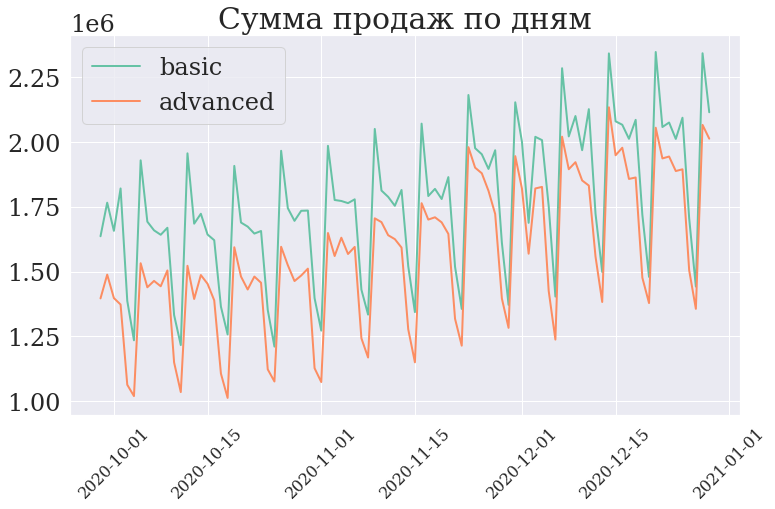

In [60]:
plt.plot(amount_ttl_through_time.xs('basic'), label='basic')
plt.plot(amount_ttl_through_time.xs('advanced'), label='advanced')
plt.xticks(rotation=45)
plt.title('Сумма продаж по дням')
plt.legend()
plt.show()

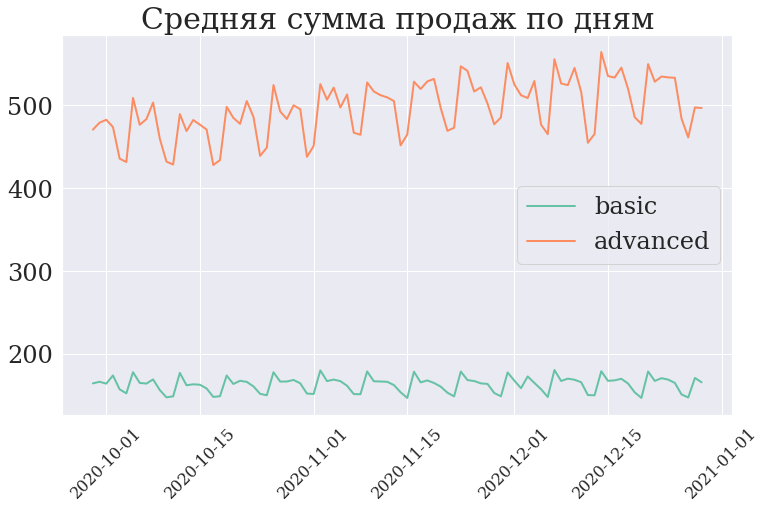

In [64]:
plt.plot(amount_mean_through_time.xs('basic'), label='basic')
plt.plot(amount_mean_through_time.xs('advanced'), label='advanced')
plt.xticks(rotation=45)
plt.title('Средняя сумма продаж по дням')
plt.legend()
plt.show()

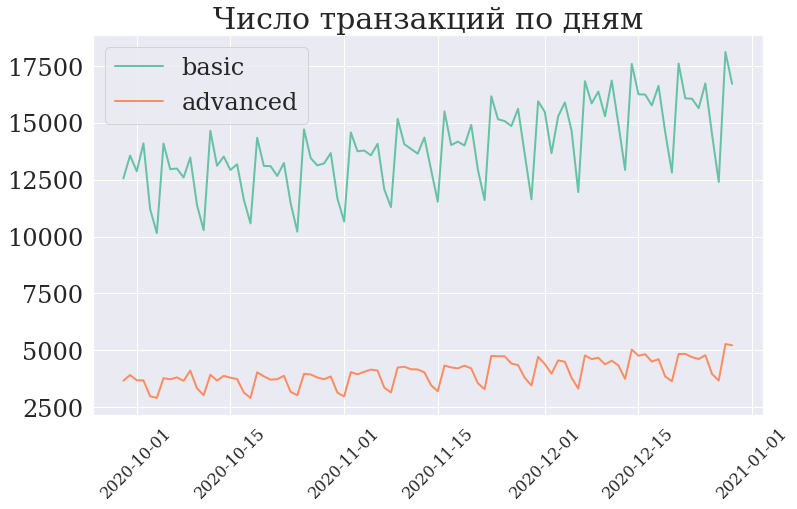

In [61]:
plt.plot(transactions_through_time.xs('basic'), label='basic')
plt.plot(transactions_through_time.xs('advanced'), label='advanced')
plt.xticks(rotation=45)
plt.title('Число транзакций по дням')
plt.legend()
plt.show()

Суммарное число транзакций -- бессмысленная метрика. Как мы видели ранее, в основном юзеры совершают 1 транзакцию за раз, в итоге наша метрика сводится к числу пользователей того или иного типа продукта

**Вывод:**  
Видна явная недельная сезональность + возрастающий тренд. Видна нетипичная просадка 2 декаюря 2020 года

Отношение базовых и продвинутых юзеров по дням

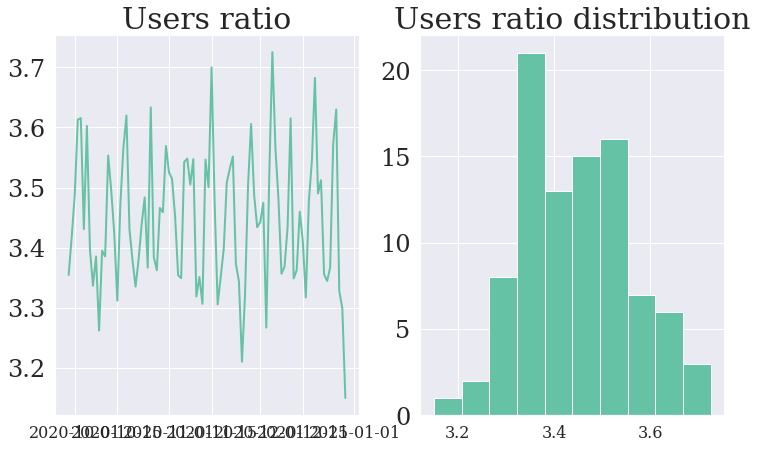

In [84]:
users_through_time = df.groupby(['product', 'event_date'])['user_id'].count()
users_ratio = users_through_time.xs('basic') / users_through_time.xs('advanced')

fig, axes = plt.subplots(1, 2)
axes[0].plot(users_ratio)
axes[0].set_title('Users ratio')
axes[1].hist(users_ratio)
axes[1].set_title('Users ratio distribution')

plt.show()

Средняя выручка и число юзеров, совершивших покупку, по дням 

In [93]:
revenue_through_time = df.groupby(['event_date'])['amount'].mean()
users_through_time = df.groupby(['event_date'])['user_id'].count()

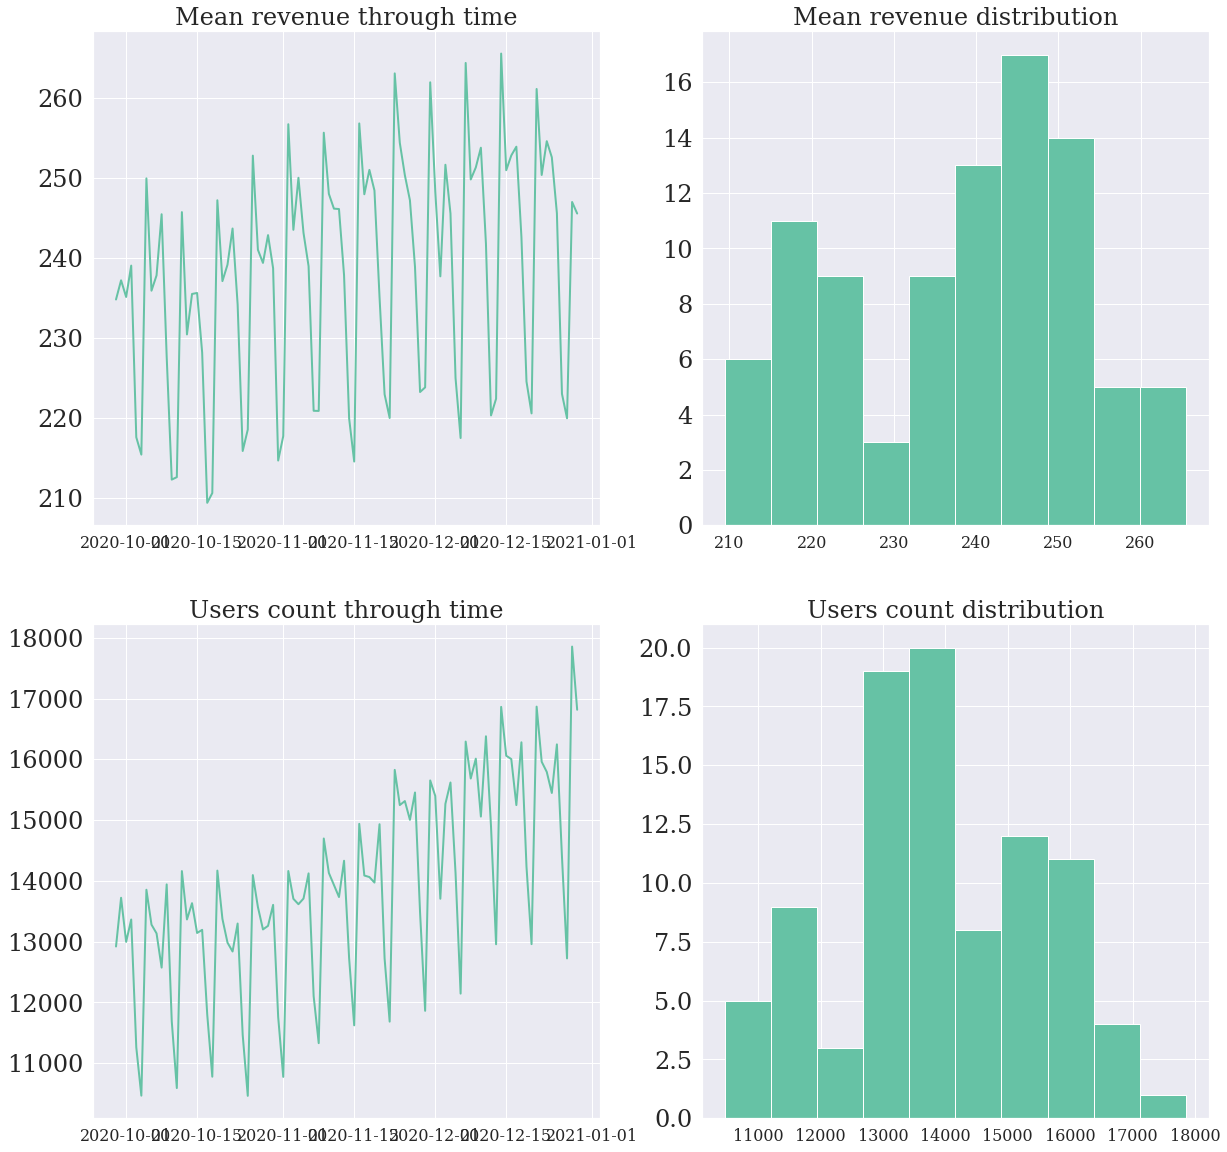

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0, 0].plot(revenue_through_time)
axes[0, 1].hist(revenue_through_time)
axes[1, 0].plot(users_through_time)
axes[1, 1].hist(users_through_time)

axes[0, 0].set_title('Mean revenue through time', fontsize=24)
axes[0, 1].set_title('Mean revenue distribution', fontsize=24)
axes[1, 0].set_title('Users count through time', fontsize=24)
axes[1, 1].set_title('Users count distribution', fontsize=24)

plt.show()

**Рассматриваемые метрики:**  
1. Общая выручка (по дням) -- основная метрика, которую хотим повычить. Бимодальное распределение  
2. Количество пользователей (по дням) -- больше юзеров, больше кэша + лакмусовая бумажка для определения того, что во время проверки 2ой гипотезы всё не пошло в тартарары. Бимодальное распределение  
3. Доля пользователей по дням -- идея такая: чем больше доля юзеров с продвинутым продуктом, тем больше выручка. Но нужно следить за отсутствием оттока пользователей. Околонормальное распределение  

Все метрики подвержены недельной сезональности: видна сильная просадка в выходные. В результате чего распределения метрик бимодальны, а не унимодальны. Я проблем с этим особо не вижу, так что оставим всё как есть. Но можно было бы не считать метрики в выходные дни, как самый простой вариант решения данной загвоздки.

**Оценка изменения метрик:**  
Применим простой вариант -- используем изменение метрик за предыдущий квартал. То есть мы ожидаем аналогичный рост метрик

In [98]:
print('Средняя выручка в первую неделю:', revenue_through_time[:7].mean())
print('Средняя выручка в последнюю неделю:', revenue_through_time[-7:].mean())
print('В процентах:', (revenue_through_time[-7:].mean() - revenue_through_time[:7].mean()) / revenue_through_time[:7].mean() * 100)

Средняя выручка в первую неделю: 232.73723318664727
Средняя выручка в последнюю неделю: 241.17897997284788
В процентах: 3.6271578340155908


In [99]:
print('Средняя выручка в первую неделю:', users_through_time[:7].mean())
print('Средняя выручка в последнюю неделю:', users_through_time[-7:].mean())
print('В процентах:', (users_through_time[-7:].mean() - users_through_time[:7].mean()) / users_through_time[:7].mean() * 100)

Средняя выручка в первую неделю: 12654.857142857143
Средняя выручка в последнюю неделю: 15611.285714285714
В процентах: 23.362006682922416
